时间序列分析

In [17]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm 
import seaborn as sns 
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/zhangyikun/Desktop/BTCUSDT_past_year_stock_data.csv', parse_dates=['candle_begin_time_GMT8'], index_col='candle_begin_time_GMT8')
df = df.sort_index()  # 按日期排序
print(df.head())

                        Unnamed: 0     open     high      low    close  \
candle_begin_time_GMT8                                                   
2022-03-20 08:00:00              0  42188.2  42269.3  40900.0  41261.0   
2022-03-21 08:00:00              1  41261.0  41544.4  40430.0  40982.0   
2022-03-22 08:00:00              2  40982.0  43517.7  40852.0  42349.8   
2022-03-23 08:00:00              3  42349.9  43051.0  41731.3  42867.9   
2022-03-24 08:00:00              4  42867.8  44200.0  42525.0  43973.4   

                            volume  
candle_begin_time_GMT8              
2022-03-20 08:00:00     235774.129  
2022-03-21 08:00:00     308396.460  
2022-03-22 08:00:00     374297.674  
2022-03-23 08:00:00     282631.740  
2022-03-24 08:00:00     331440.057  


In [8]:
df = df.dropna()

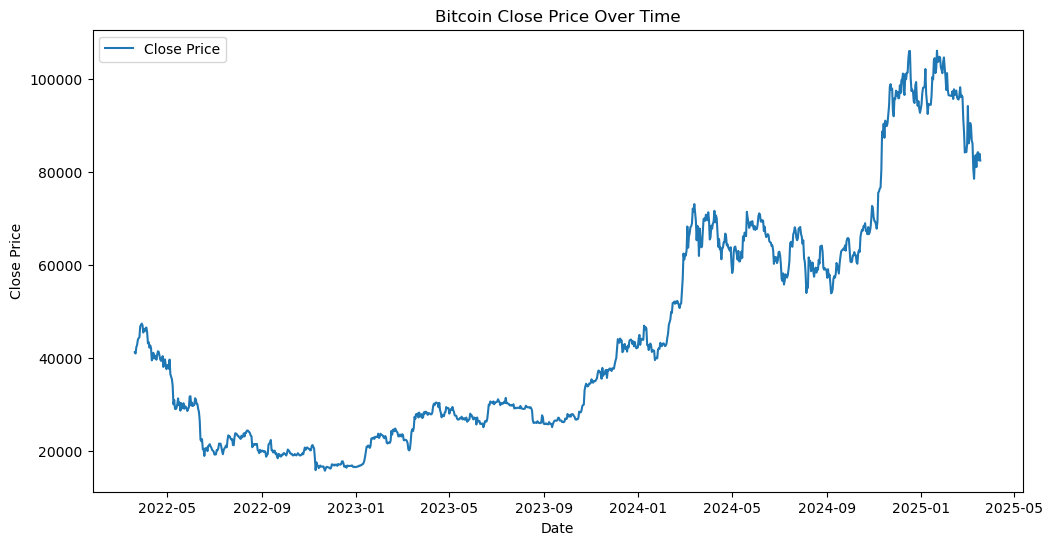

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

平稳性检验

In [22]:
from statsmodels.tsa.stattools import adfuller

df['log_return'] = np.log(df['close']).diff()   #对close价格取对数
df.dropna(inplace=True)   #去首行

result = adfuller(df['log_return'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -22.497134495457495
p-value: 0.0
Critical Values: {'1%': -3.436352507699052, '5%': -2.86419037625175, '10%': -2.56818114683546}


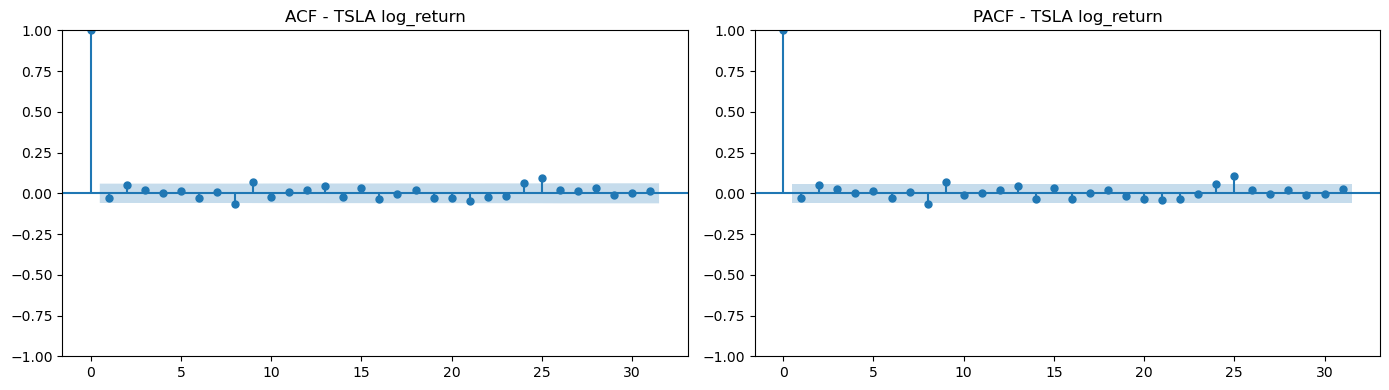

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(14, 4))  

# ACF
plot_acf(df['log_return'], ax=axes[0], title="ACF - TSLA log_return")  
# PACF
plot_pacf(df['log_return'], ax=axes[1], title="PACF - TSLA log_return")  

plt.tight_layout()  
plt.show()

ADF 统计量（-22.497）远小于 1% 临界值（-3.436），且 p 值为 0.0，说明拒绝原假设（序列非平稳）说明对数收益率序列是平稳的。
ACF 和 PACF 图显示，对数收益率序列几乎没有显著的自相关或偏自相关性。对数收益率序列可能是一个 白噪声过程，即没有可预测的线性结构。

根据deepseek的建议，下一步可以；
下一步可以：
    分析波动率是否存在聚集效应 ——可以计算 绝对收益率 或 平方收益率，并绘制它们的 ACF 和 PACF 图
    使用 GARCH 模型对波动率建模。
    尝试非线性模型（如 LSTM）。

分析波动率——计算 绝对收益率 或 平方收益率，并绘制它们的 ACF 和 PACF 图

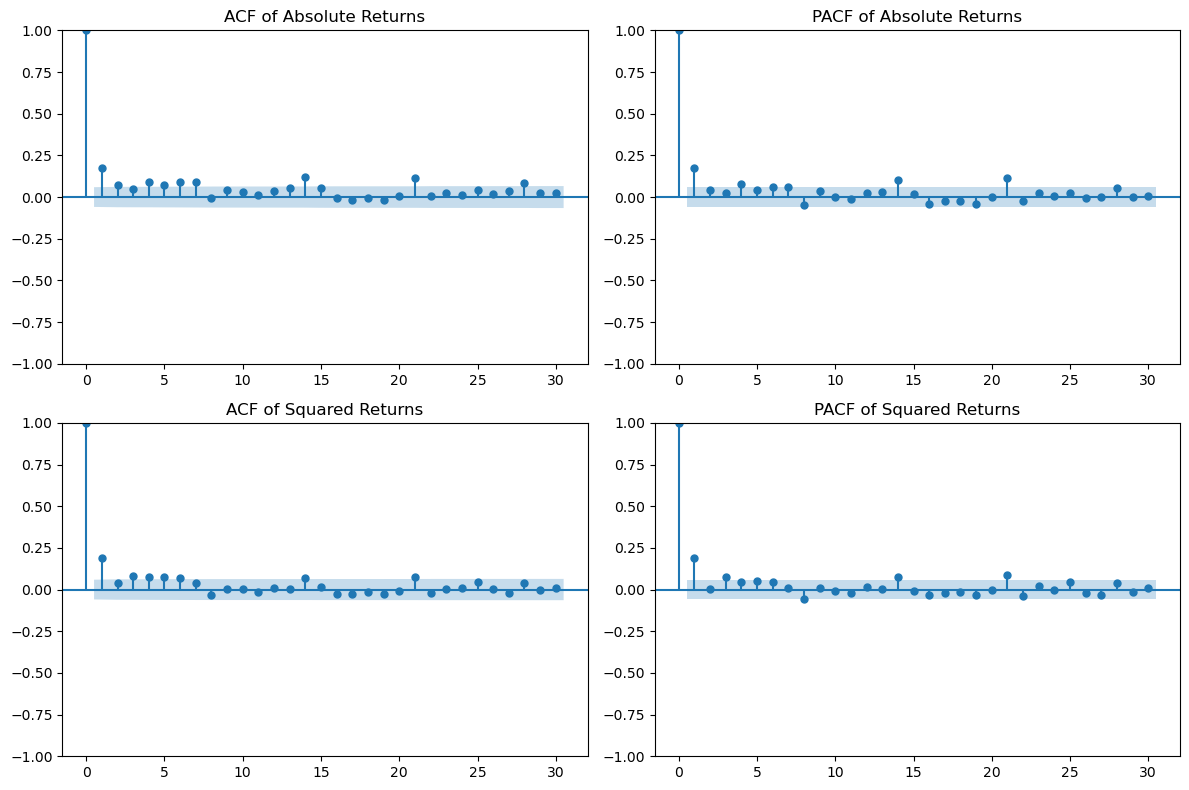

In [25]:
df['abs_ret'] = df['log_return'].abs()
df['sq_ret'] = df['log_return'] ** 2

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df['abs_ret'].dropna(), lags=30, ax=axes[0,0], title="ACF of Absolute Returns")
plot_pacf(df['abs_ret'].dropna(), lags=30, ax=axes[0,1], title="PACF of Absolute Returns")
plot_acf(df['sq_ret'].dropna(), lags=30, ax=axes[1,0], title="ACF of Squared Returns")
plot_pacf(df['sq_ret'].dropna(), lags=30, ax=axes[1,1], title="PACF of Squared Returns")
plt.tight_layout()
plt.show()

这些图表明收益率的绝对值和平方在短期内（特别是滞后1期）存在显著的自相关性，这可能暗示了波动聚集效应，即在金融时间序列中常见的现象：大波动往往跟随大波动，小波动往往跟随小波动。这种特性通常可以通过GARCH模型来捕捉和建模。

使用GARCH模型

In [27]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 946.5/946.5 kB 18.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
from arch import arch_model

# 拟合 GARCH(1,1) 模型
model = arch_model(df['log_return'], vol='Garch', p=1, q=1)
results = model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 49330365.40136365
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1238.3214916521742
Iteration:      3,   Func. Count:     25,   Neg. LLF: 401534618.9901837
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1323.0092692780013
Iteration:      5,   Func. Count:     39,   Neg. LLF: -2384.649415339434
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1637.6597020417407
Iteration:      7,   Func. Count:     52,   Neg. LLF: -2401.684761708775
Iteration:      8,   Func. Count:     58,   Neg. LLF: -2414.6117420554824
Iteration:      9,   Func. Count:     63,   Neg. LLF: -2414.720900049242
Iteration:     10,   Func. Count:     68,   Neg. LLF: -2414.730087563562
Iteration:     11,   Func. Count:     73,   Neg. LLF: -2414.730385625557
Iteration:     12,   Func. Count:     78,   Neg. LLF: -2414.7305365366265
Iteration:     13,   Func. Count:     82,   Neg. LLF: -2414.7305365369925
Optimization terminated successfully    (Exit mod

/Users/zhangyikun/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007721. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


对数似然值、AIC、BIC说明GARCH(1,1) 模型能够很好地捕捉波动率的动态特征，波动率具有显著的持续性和 ARCH 效应。
p 值为 0.112，大于 0.05，说明均值方程的常数项不显著，这表明对数收益率的均值可能接近于 0，或者均值部分没有显著的可预测性。

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 获取 GARCH 模型的残差
residuals = results.resid

# 进行 Ljung-Box 检验
lb_test = acorr_ljungbox(residuals, lags=[10])  # 检验滞后 10 阶

# 打印 p 值
print("Ljung-Box test p-value:", lb_test['lb_pvalue'].iloc[0])

Ljung-Box test p-value: 0.07136010665792068


p 值大于 0.05，说明不能拒绝原假设，认为残差是白噪声

波动率预测：使用 GARCH 模型预测未来波动率

In [32]:
# 使用 GARCH 模型预测未来波动率
forecasts = results.forecast(horizon=5)  # 预测未来 5 期的波动率

# 提取条件波动率（conditional volatility）
conditional_volatility = forecasts.variance.iloc[-1]  # 最后一期的条件波动率
print("Conditional Volatility Forecast:")
print(conditional_volatility)

Conditional Volatility Forecast:
h.1    0.000648
h.2    0.000675
h.3    0.000697
h.4    0.000715
h.5    0.000730
Name: 2025-03-18 08:00:00, dtype: float64


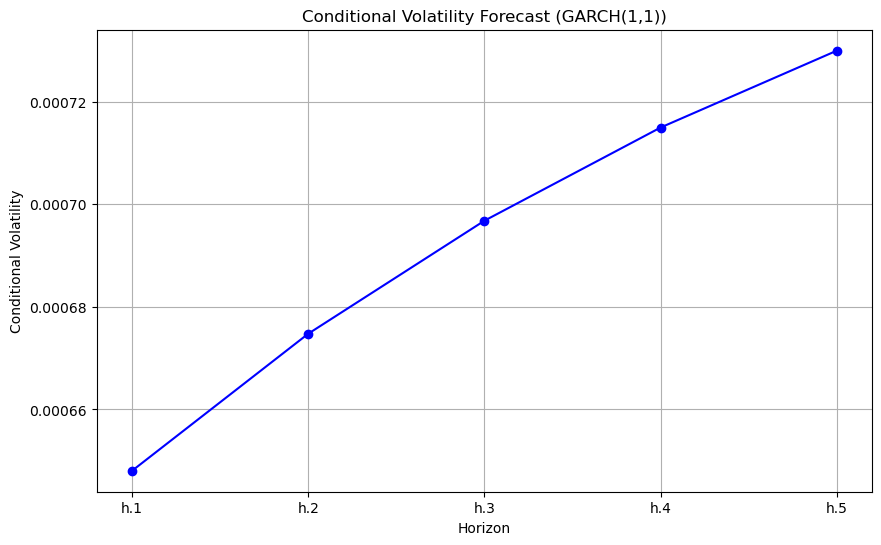

In [33]:
import matplotlib.pyplot as plt

# 绘制波动率预测
plt.figure(figsize=(10, 6))
plt.plot(conditional_volatility, marker='o', linestyle='-', color='b')
plt.title('Conditional Volatility Forecast (GARCH(1,1))')
plt.xlabel('Horizon')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

总结
对数收益率的均值: 没有显著的可预测性（均值方程的常数项不显著）。
波动率: 具有显著的持续性和 ARCH 效应，说明波动率存在聚集效应（即高波动率会持续一段时间）。
模型拟合效果: GARCH(1,1) 模型的 AIC 和 BIC 值较低，说明模型拟合效果较好。
波动率预测: 未来 5 期的波动率预测值可以用于评估未来的风险或波动性。

1. ARIMA 和 GARCH 模型的关系

ARIMA 模型:
用于建模和预测时间序列的 均值部分。
通过自回归（AR）、差分（I）和滑动平均（MA）捕捉序列的线性结构。
GARCH 模型:
用于建模和预测时间序列的 波动率部分。
通过 ARCH 和 GARCH 项捕捉波动率的聚集效应。
关系:
ARIMA 和 GARCH 可以结合使用，形成 ARIMA-GARCH 模型。
ARIMA 用于建模均值，GARCH 用于建模波动率。
例如，可以先使用 ARIMA 模型拟合均值，然后对残差使用 GARCH 模型拟合波动率。

2. 为什么有的分析对 close 价格取对数再差分，有的直接分析 close 价格？

取对数再差分:
目的是将价格序列转换为对数收益率序列。
对数收益率通常更平稳，且具有更好的统计性质（如对称性和可加性）。
适用于分析收益率的均值和波动率。
直接分析 close 价格:
如果目标是预测价格本身（而不是收益率），可以直接对价格序列建模。
但价格序列通常是非平稳的，可能需要差分或对数变换。

3. 波动率分析的作用

波动率 是衡量资产价格波动程度的指标，反映了市场风险。
波动率分析的作用:
风险管理: 预测未来波动率可以帮助投资者评估风险，制定风险管理策略。
期权定价: 波动率是期权定价模型（如 Black-Scholes 模型）的关键输入。
交易策略: 基于波动率的交易策略（如波动率套利）在金融市场中广泛应用。

4. 预测价格和收益率流程
数据准备: 收集历史价格数据，计算对数收益率。
平稳性检验: 使用 ADF 检验确认序列是否平稳。
模型选择:
如果预测收益率，可以使用 ARIMA 或 GARCH 模型。
如果预测价格本身，可以使用 ARIMA 或更复杂的模型（如 LSTM）。
模型拟合: 使用历史数据拟合模型。
模型诊断: 检验残差是否为白噪声。
预测: 使用拟合的模型预测未来价格或收益率。